# MSc Project - Machine Learning

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.simplefilter('ignore')

## Functions

In [142]:
def evaluate(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    print(f"Micro F1 Score: {micro_f1:.2f}")

    total_precision = precision_score(y_test, y_pred, average='micro')
    total_recall = recall_score(y_test, y_pred, average='micro')
    print(f"Total Precision: {total_precision:.2f}")
    print(f"Total Recall: {total_recall:.2f}")

    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)

    report = classification_report(y_test, y_pred, output_dict=True)

    report['accuracy'] = accuracy_score(y_test, y_pred)
    report['micro F1-score'] = f1_score(y_test, y_pred, average='micro')

    for key, value in report.items():
        if isinstance(value, dict): 
            print(f"{key}: Precision={value['precision']:.2f}, Recall={value['recall']:.2f}, F1-Score={value['f1-score']:.2f}")
        else:  
            print(f"{key}: {value:.2f}")
    
    return conf_matrix


In [143]:
def plot_conf(conf_matrix):
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

## Get Data

In [144]:
data = pd.read_pickle("processed_data.pkl")

In [145]:
df = data.copy()

In [146]:
df = df[[
    'Gender', 
    'EducationLevel', 
    'FemaleParentEducationGroup',
    'FemaleParentEducationLevel', 'MaleParentEducationGroup',
    'MaleParentEducationLevel', 
    'Label'
    ]].copy()

## Fixing Data for Models

In [147]:
df["Gender"] = df["Gender"].map({'Woman': 0, 'Man': 1})


education_level = {'Primary': 0, 'Secondary': 1, 'Bachelors': 2, 'Masters': 3, 'Doctoral': 4, 'Unknown': -1, None: -1}
df["EducationLevel"] = df["EducationLevel"].map(education_level)
df["FemaleParentEducationLevel"] = df["FemaleParentEducationLevel"].map(education_level)
df["MaleParentEducationLevel"] = df["MaleParentEducationLevel"].map(education_level)

education_group = {
    'Business and economics': 0, 'Engineering': 1, 'Technology': 2, 'Health': 3, 
    'Social sciences': 4, 'Natural sciences': 5, 'Arts and humanities': 6, 'Education': 7,
    'Other': -1, None: -1
    }

df["FemaleParentEducationGroup"] = df["FemaleParentEducationGroup"].map(education_group)
df["MaleParentEducationGroup"] = df["MaleParentEducationGroup"].map(education_group)

In [148]:
target_col = 'Label'

In [149]:
feature_names = df.drop(columns=[target_col]).columns.tolist()

In [150]:
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Logistic Regression

In [ ]:
# Define parameter grid
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['liblinear', 'lbfgs'],
    'logisticregression__penalty': ['l1', 'l2'],
}

scaler = StandardScaler()

# Under sampling training and testing data to prevent majority class voting only
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

log_reg = LogisticRegression(class_weight="balanced", max_iter=500)

# Create pipeline (scaling + logistic regression)
pipeline = Pipeline([
    ('scaler', scaler),
    ('logisticregression', log_reg)
])

# Define scoring metrics: Accuracy and Micro F1
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_micro': make_scorer(f1_score, average='micro')
}

# GridSearch
grid_search = GridSearchCV( pipeline, param_grid, cv=5, scoring=scoring, refit='f1_micro', n_jobs=-1)

# Fit grid search
grid_search.fit(X_resampled, y_resampled)

# Best parameters found
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])
print("Best Micro F1 Score:", grid_search.best_score_)  # Micro F1 score

best_lr = grid_search.best_estimator_

Best Parameters: {'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
Best Accuracy: 0.3
Best Micro F1 Score: 0.3


In [152]:
y_pred_lr = best_lr.predict(X_test) 
conf_matrix_lr = evaluate(y_test, y_pred_lr)

Accuracy: 0.32
Micro F1 Score: 0.32
Total Precision: 0.32
Total Recall: 0.32
[[18 27  4  8]
 [ 1  3  1  0]
 [ 2  3  1  2]
 [ 0  0  0  1]]
0: Precision=0.86, Recall=0.32, F1-Score=0.46
1: Precision=0.09, Recall=0.60, F1-Score=0.16
2: Precision=0.17, Recall=0.12, F1-Score=0.14
3: Precision=0.09, Recall=1.00, F1-Score=0.17
accuracy: 0.32
macro avg: Precision=0.30, Recall=0.51, F1-Score=0.23
weighted avg: Precision=0.71, Recall=0.32, F1-Score=0.40
micro F1-score: 0.32


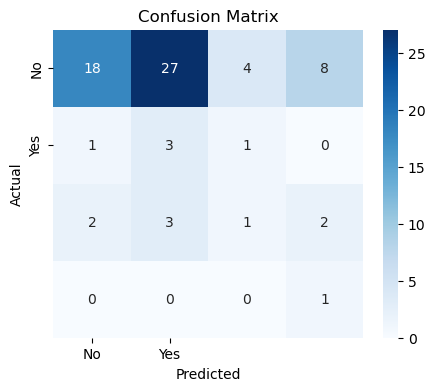

In [153]:
plot_conf(conf_matrix_lr)

**Feature importances**

In [154]:
X_train = pd.DataFrame(X_train, columns=feature_names)

# Get feature importance from coefficients
importances = np.abs(best_lr.named_steps['logisticregression'].coef_).mean(axis=0)
sorted_indices = np.argsort(importances)[::-1]

# Print top important features
for idx in sorted_indices:
    print(f"{X_train.columns[idx]}: {importances[idx]:.4f}")

FemaleParentEducationLevel: 0.9065
MaleParentEducationLevel: 0.6270
MaleParentEducationGroup: 0.5637
FemaleParentEducationGroup: 0.5443
EducationLevel: 0.4344
Gender: 0.3729


## Decision Tree

In [ ]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 10, 12, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4], 
    'criterion': ['gini', 'entropy']
}

# Compute class weights to balance class imbalance
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# Initialize Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict)

# Define scoring metrics: Accuracy and Micro F1
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_micro': make_scorer(f1_score, average='micro')
}

# Perform GridSearch
grid_search = GridSearchCV(clf, param_grid, cv=10, scoring=scoring, refit='f1_micro', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])
print("Best Micro F1 Score:", grid_search.best_score_) 

best_dt = grid_search.best_estimator_


Best Parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy: 0.7791871921182265
Best Micro F1 Score: 0.7791871921182266


In [156]:
y_pred_dt = best_dt.predict(X_test)
conf_matrix_dt = evaluate(y_test, y_pred_dt)

Accuracy: 0.66
Micro F1 Score: 0.66
Total Precision: 0.66
Total Recall: 0.66
[[42  9  5  1]
 [ 4  1  0  0]
 [ 1  3  3  1]
 [ 0  0  0  1]]
0: Precision=0.89, Recall=0.74, F1-Score=0.81
1: Precision=0.08, Recall=0.20, F1-Score=0.11
2: Precision=0.38, Recall=0.38, F1-Score=0.38
3: Precision=0.33, Recall=1.00, F1-Score=0.50
accuracy: 0.66
macro avg: Precision=0.42, Recall=0.58, F1-Score=0.45
weighted avg: Precision=0.77, Recall=0.66, F1-Score=0.71
micro F1-score: 0.66


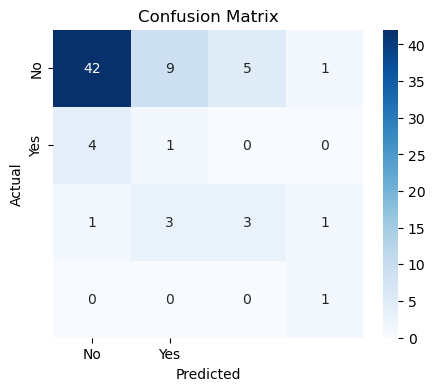

In [157]:
plot_conf(conf_matrix_dt)

**Feature importances**

In [158]:
X_train = pd.DataFrame(X_train, columns=feature_names) 

importances = best_dt.feature_importances_
sorted_indices = importances.argsort()[::-1]

# Print top important features
for idx in sorted_indices:
    print(f"{X_train.columns[idx]}: {importances[idx]:.4f}")

MaleParentEducationGroup: 0.3675
FemaleParentEducationGroup: 0.3374
FemaleParentEducationLevel: 0.1097
MaleParentEducationLevel: 0.0716
Gender: 0.0589
EducationLevel: 0.0548


## Random Forest

In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.7]
}

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

rf = RandomForestClassifier(random_state=42, oob_score=True, class_weight=class_weight_dict)

# Define scoring metrics: Accuracy and Micro F1
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_micro': make_scorer(f1_score, average='micro')
}

# Perform GridSearch
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring=scoring, refit='f1_micro', n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])
print("Best Micro F1 Score:", grid_search.best_score_)  # Micro F1 score
print("OOB Score:", grid_search.best_estimator_.oob_score_)

best_rf = grid_search.best_estimator_


Best Parameters: {'max_depth': 10, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best Accuracy: 0.7758620689655172
Best Micro F1 Score: 0.7758620689655172
OOB Score: 0.7464788732394366


In [160]:
y_pred_rf = best_rf.predict(X_test)
conf_matrix_rf = evaluate(y_test, y_pred_rf)

Accuracy: 0.72
Micro F1 Score: 0.72
Total Precision: 0.72
Total Recall: 0.72
[[42  8  7  0]
 [ 2  1  2  0]
 [ 0  0  8  0]
 [ 1  0  0  0]]
0: Precision=0.93, Recall=0.74, F1-Score=0.82
1: Precision=0.11, Recall=0.20, F1-Score=0.14
2: Precision=0.47, Recall=1.00, F1-Score=0.64
3: Precision=0.00, Recall=0.00, F1-Score=0.00
accuracy: 0.72
macro avg: Precision=0.38, Recall=0.48, F1-Score=0.40
weighted avg: Precision=0.81, Recall=0.72, F1-Score=0.74
micro F1-score: 0.72


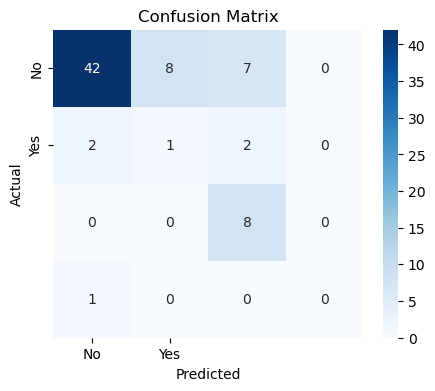

In [161]:
plot_conf(conf_matrix_rf)

**Feature importances**

In [162]:
X_train = pd.DataFrame(X_train, columns=feature_names) 

importances = best_rf.feature_importances_
sorted_indices = importances.argsort()[::-1]

# Print top important features
for idx in sorted_indices:
    print(f"{X_train.columns[idx]}: {importances[idx]:.4f}")

MaleParentEducationGroup: 0.3181
FemaleParentEducationGroup: 0.3099
FemaleParentEducationLevel: 0.1216
EducationLevel: 0.1048
MaleParentEducationLevel: 0.0983
Gender: 0.0474


## XGBoost

In [163]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [3, 5, 7],  # Maximum depth of a tree
    'min_child_weight': [1, 3, 5],  # Minimum sum of weights in a child node
    'gamma': [0, 0.1, 0.3],  # Minimum loss reduction required to make a split
    'subsample': [0.7, 1.0],  # Fraction of samples used per tree
    'colsample_bytree': [0.7, 1.0]  # Fraction of features used per tree
}

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Define scoring metrics: Accuracy and Micro F1
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_micro': make_scorer(f1_score, average='micro')
}

# Perform GridSearch
grid_search = GridSearchCV(xgb_clf, param_grid, cv=10, scoring=scoring, refit='f1_micro', n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])
print("Best Micro F1 Score:", grid_search.best_score_)  # Micro F1 score

best_xgb = grid_search.best_estimator_

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 1.0}
Best Accuracy: 0.8318965517241379
Best Micro F1 Score: 0.8318965517241379


In [164]:
y_pred_xgb = best_xgb.predict(X_test)
conf_matrix_xgb = evaluate(y_test, y_pred_xgb)

Accuracy: 0.80
Micro F1 Score: 0.80
Total Precision: 0.80
Total Recall: 0.80
[[50  5  2  0]
 [ 2  1  2  0]
 [ 2  0  6  0]
 [ 1  0  0  0]]
0: Precision=0.91, Recall=0.88, F1-Score=0.89
1: Precision=0.17, Recall=0.20, F1-Score=0.18
2: Precision=0.60, Recall=0.75, F1-Score=0.67
3: Precision=0.00, Recall=0.00, F1-Score=0.00
accuracy: 0.80
macro avg: Precision=0.42, Recall=0.46, F1-Score=0.44
weighted avg: Precision=0.81, Recall=0.80, F1-Score=0.80
micro F1-score: 0.80


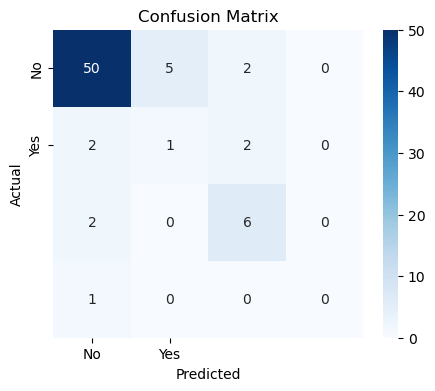

In [165]:
plot_conf(conf_matrix_xgb)

**Feature importances**

In [166]:
X_train = pd.DataFrame(X_train, columns=feature_names) 

importances = best_xgb.feature_importances_
sorted_indices = importances.argsort()[::-1]

# Print top important features
for idx in sorted_indices:
    print(f"{X_train.columns[idx]}: {importances[idx]:.4f}")

MaleParentEducationGroup: 0.2506
FemaleParentEducationGroup: 0.2011
Gender: 0.1722
MaleParentEducationLevel: 0.1363
EducationLevel: 0.1315
FemaleParentEducationLevel: 0.1084


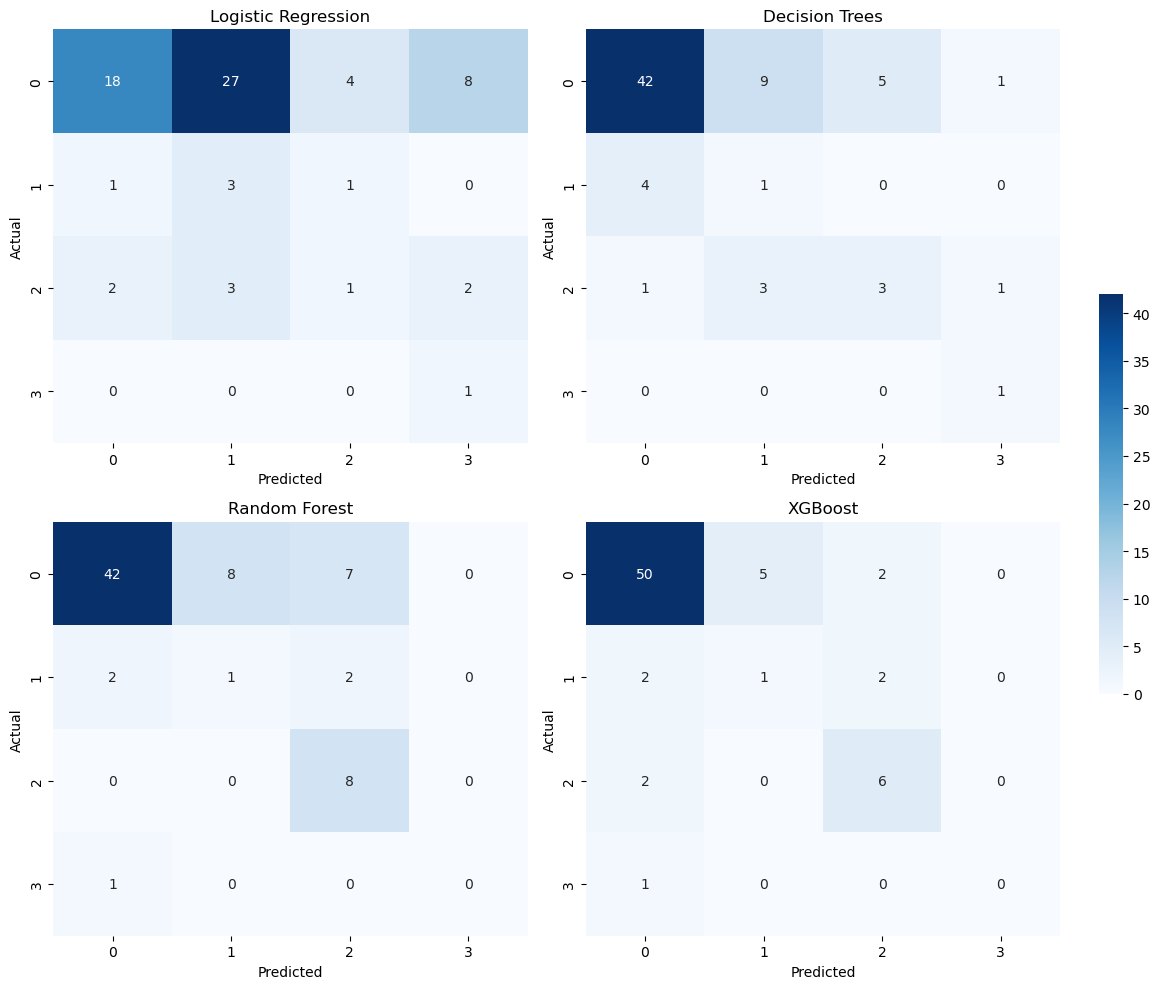

In [167]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot each heatmap
sns.heatmap(conf_matrix_lr, ax=axes[0, 0], cmap="Blues", cbar=False, annot=True)
axes[0, 0].set_title("Logistic Regression")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("Actual")

sns.heatmap(conf_matrix_dt, ax=axes[0, 1], cmap="Blues", cbar=False, annot=True)
axes[0, 1].set_title("Decision Trees")
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("Actual")

sns.heatmap(conf_matrix_rf, ax=axes[1, 0], cmap="Blues", annot=True, cbar=True, cbar_ax=fig.add_axes([0.92, 0.3, 0.02, 0.4]))
axes[1, 0].set_title("Random Forest")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("Actual")

sns.heatmap(conf_matrix_xgb, ax=axes[1, 1], cmap="Blues", cbar=False, annot=True)
axes[1, 1].set_title("XGBoost")
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("Actual")

plt.tight_layout(rect=[0, 0, 0.9, 1])

plt.show()
